<a href="https://colab.research.google.com/github/Nandakumar1381/Nexus/blob/main/Nexus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from tqdm.notebook import tqdm as tqdm_notebook
from sklearn.preprocessing import MinMaxScaler

In [3]:
data_dir = "/content/drive/MyDrive/Important/archive"
print(os.listdir(data_dir))

['AEP_hourly.csv', 'COMED_hourly.csv', 'DAYTON_hourly.csv', 'DOM_hourly.csv', 'DEOK_hourly.csv', 'DUQ_hourly.csv', 'EKPC_hourly.csv', 'est_hourly.paruqet', 'FE_hourly.csv', 'NI_hourly.csv', 'pjm_hourly_est.csv', 'PJM_Load_hourly.csv', 'PJMW_hourly.csv', 'PJME_hourly.csv']


In [4]:
pd.read_csv(os.path.join(data_dir, "DEOK_hourly.csv")).head()

,Datetime,DEOK_MW
0,2012-12-31 01:00:00,2945.0
1,2012-12-31 02:00:00,2868.0
2,2012-12-31 03:00:00,2812.0
3,2012-12-31 04:00:00,2812.0
4,2012-12-31 05:00:00,2860.0


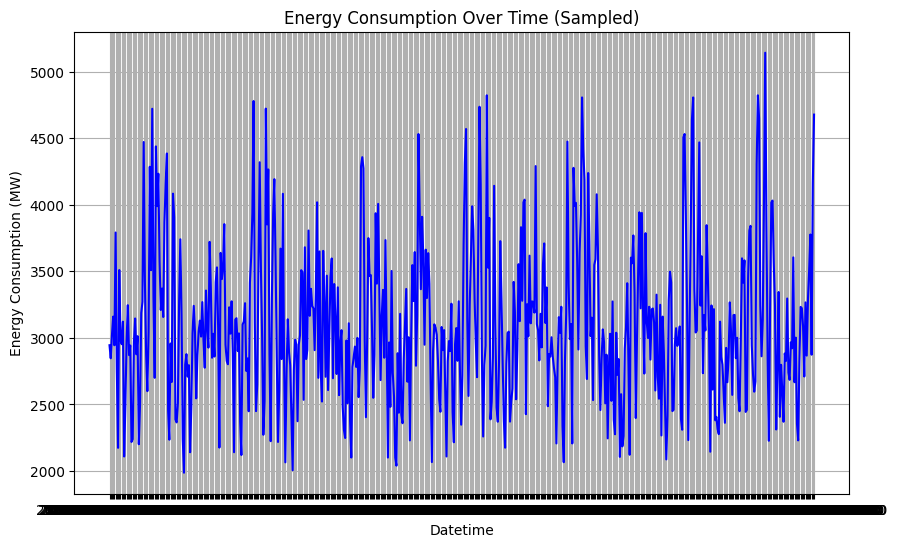

In [5]:
csv_file_path = os.path.join(data_dir, "DEOK_hourly.csv")
df = pd.read_csv(csv_file_path)
sampled_df = df[::100]
plt.figure(figsize=(10, 6))
plt.plot(sampled_df['Datetime'], sampled_df['DEOK_MW'], color='blue')
plt.title('Energy Consumption Over Time (Sampled)')
plt.xlabel('Datetime')
plt.ylabel('Energy Consumption (MW)')
plt.grid(True)
plt.show()

In [6]:
def move_sliding_window(data, window_size, inputs_cols_indices, label_col_index):
    inputs = np.zeros((len(data) - window_size, window_size, len(inputs_cols_indices)))
    labels = np.zeros(len(data) - window_size)

    for i in range(window_size, len(data)):
        inputs[i - window_size] = data[i - window_size : i, inputs_cols_indices]
        labels[i - window_size] = data[i, label_col_index]
    inputs = inputs.reshape(-1, window_size, len(inputs_cols_indices))
    labels = labels.reshape(-1, 1)
    print(inputs.shape, labels.shape)

    return inputs, labels

In [7]:
label_col_index = 0
inputs_cols_indices = range(
    5
)
window_size = 90

label_scalers = {}

train_x = []
test_x = {}
test_y = {}

processing_files = [
    file for file in os.listdir(data_dir) if os.path.splitext(file)[1] == ".csv"
]

num_files_for_dataset = 5

for file in tqdm_notebook(processing_files[:num_files_for_dataset]):
    print(f"Processing {file} ...")

    df = pd.read_csv(os.path.join(data_dir, file), parse_dates=["Datetime"])


    df["hour"] = df.apply(lambda x: x["Datetime"].hour, axis=1)
    df["dayofweek"] = df.apply(lambda x: x["Datetime"].dayofweek, axis=1)
    df["month"] = df.apply(lambda x: x["Datetime"].month, axis=1)
    df["dayofyear"] = df.apply(lambda x: x["Datetime"].dayofyear, axis=1)
    df = df.sort_values("Datetime").drop("Datetime", axis=1)

    sc = MinMaxScaler()
    label_sc = MinMaxScaler()
    data = sc.fit_transform(df.values)

    label_sc.fit(df.iloc[:, label_col_index].values.reshape(-1, 1))
    label_scalers[file] = label_sc

    inputs, labels = move_sliding_window(
        data,
        window_size,
        inputs_cols_indices=inputs_cols_indices,
        label_col_index=label_col_index,
    )


    test_portion = int(0.1 * len(inputs))
    if len(train_x) == 0:
        train_x = inputs[:-test_portion]
        train_y = labels[:-test_portion]
    else:
        train_x = np.concatenate((train_x, inputs[:-test_portion]))
        train_y = np.concatenate((train_y, labels[:-test_portion]))
    test_x[file] = inputs[-test_portion:]
    test_y[file] = labels[-test_portion:]

  0%|          | 0/5 [00:00<?, ?it/s]

Processing AEP_hourly.csv ...
(121183, 90, 5) (121183, 1)
Processing COMED_hourly.csv ...
(66407, 90, 5) (66407, 1)
Processing DAYTON_hourly.csv ...
(121185, 90, 5) (121185, 1)
Processing DOM_hourly.csv ...
(116099, 90, 5) (116099, 1)
Processing DEOK_hourly.csv ...
(57649, 90, 5) (57649, 1)


In [8]:
train_x.shape, test_x["DEOK_hourly.csv"].shape

((434274, 90, 5), (5764, 90, 5))

In [9]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("CPU")

GPU is available


In [10]:
batch_size = 1024

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))

train_loader = DataLoader(
    train_data, shuffle=True, batch_size=batch_size, drop_last=True
)

In [11]:
del train_x, train_y

In [12]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.gru = nn.GRU(
            input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:, -1]))
        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (
            weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        )
        return hidden


class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
            input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:, -1]))
        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (
            weight.new(self.n_layers, batch_size, self.hidden_dim)
            .zero_()
            .to(device),
            weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
        )
        return hidden

In [13]:
def train(
    train_loader,
    learn_rate,
    hidden_dim=256,
    n_layers=2,
    n_epochs=5,
    model_type="GRU",
    print_every=100,
):

    input_dim = next(iter(train_loader))[0].shape[2]  # 5

    # Batch generator (train_data, train_label)
    # print(next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape) # torch.Size([1024, 90, 5]) torch.Size([1024, 1])

    output_dim = 1

    # Instantiating the models
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)

    # Defining loss function and optimizer
    criterion = nn.MSELoss()  # Mean Squared Error
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []

    # Start training loop
    for epoch in range(1, n_epochs + 1):
        start_time = time.process_time()
        h = model.init_hidden(batch_size)
        avg_loss = 0.0
        counter = 0
        for x, label in train_loader:
            counter += 1
            if model_type == "GRU":
                h = h.data
            # Unpcak both h_0 and c_0
            elif model_type == "LSTM":
                h = tuple([e.data for e in h])

            # Set the gradients to zero before starting to do backpropragation because
            # PyTorch accumulates the gradients on subsequent backward passes
            model.zero_grad()

            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())

            # Perform backpropragation
            loss.backward()
            optimizer.step()

            avg_loss += loss.item()
            if counter % print_every == 0:
                print(
                    f"Epoch {epoch} - Step: {counter}/{len(train_loader)} - Average Loss for Epoch: {avg_loss/counter}"
                )
        current_time = time.process_time()

        print(
            f"Epoch {epoch}/{n_epochs} Done, Total Loss: {avg_loss/len(train_loader)}"
        )

        print(f"Time Elapsed for Epoch: {current_time-start_time} seconds")

        epoch_times.append(current_time - start_time)

    print(f"Total Training Time: {sum(epoch_times)} seconds")
    return model

In [14]:
# seq_len = 90  # (timestamps)
n_hidden = 256
n_layers = 2
n_epochs = 5
print_every = 100
lr = 0.001
gru_model = train(
    train_loader,
    learn_rate=lr,
    hidden_dim=n_hidden,
    n_layers=n_layers,
    n_epochs=n_epochs,
    model_type="GRU",
    print_every=print_every,
)

Starting Training of GRU model
Epoch 1 - Step: 100/424 - Average Loss for Epoch: 0.01158024383126758
Epoch 1 - Step: 200/424 - Average Loss for Epoch: 0.006451550881029107
Epoch 1 - Step: 300/424 - Average Loss for Epoch: 0.004579535549273714
Epoch 1 - Step: 400/424 - Average Loss for Epoch: 0.003588636249405681
Epoch 1/5 Done, Total Loss: 0.0034141520383923736
Time Elapsed for Epoch: 55.086426281 seconds
Epoch 2 - Step: 100/424 - Average Loss for Epoch: 0.0004938888645847329
Epoch 2 - Step: 200/424 - Average Loss for Epoch: 0.00044475855960627084
Epoch 2 - Step: 300/424 - Average Loss for Epoch: 0.00041417785658268255
Epoch 2 - Step: 400/424 - Average Loss for Epoch: 0.0003816932998233824
Epoch 2/5 Done, Total Loss: 0.0003763282725659972
Time Elapsed for Epoch: 59.31413482700002 seconds
Epoch 3 - Step: 100/424 - Average Loss for Epoch: 0.00030223240100895054
Epoch 3 - Step: 200/424 - Average Loss for Epoch: 0.0002744896515650908
Epoch 3 - Step: 300/424 - Average Loss for Epoch: 0.0002

In [15]:

torch.save(gru_model.state_dict(), "/content/drive/MyDrive/Important/model/gru_model.pt")

In [ ]:
lstm_model = train(
    train_loader,
    learn_rate=lr,
    hidden_dim=n_hidden,
    n_layers=n_layers,
    n_epochs=n_epochs,
    model_type="LSTM",
    print_every=print_every,
)

Starting Training of LSTM model


In [ ]:
torch.save(lstm_model.state_dict(), "/content/drive/MyDrive/Important/model/lstm_model.pt")

In [ ]:
device="cpu"

In [ ]:
hidden_dim = 256
input_dim = 5
output_dim = 1
n_layers = 2
gru_model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
gru_model.load_state_dict(torch.load("/content/drive/MyDrive/Important/model/gru_model.pt"))

In [ ]:
gru_model.to(device)

In [ ]:
hidden_dim = 256
input_dim = 5
output_dim = 1
n_layers = 2
lstm_model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
lstm_model.load_state_dict(torch.load("/content/drive/MyDrive/Important/model/lstm_model.pt"))

In [ ]:
lstm_model.to(device)

In [ ]:
def sMAPE(outputs, targets):
    sMAPE = (
        100
        / len(targets)
        * np.sum(np.abs(outputs - targets) / (np.abs(outputs + targets)) / 2)
    )
    return sMAPE

In [ ]:
def evaluate(model, test_x, test_y, label_scalers):
    model.eval()
    outputs = []
    targets = []
    start_time = time.process_time()
    # get data of test data for each state
    for file in test_x.keys():
        inputs = torch.from_numpy(np.array(test_x[file]))
        labels = torch.from_numpy(np.array(test_y[file]))

        h = model.init_hidden(inputs.shape[0])

        # predict outputs
        with torch.no_grad():
            out, h = model(inputs.to(device).float(), h)

        outputs.append(
            label_scalers[file]
            .inverse_transform(out.cpu().detach().numpy())
            .reshape(-1)
        )

        targets.append(
            label_scalers[file].inverse_transform(labels.numpy()).reshape(-1)
        )

    # Merge all files
    concatenated_outputs = np.concatenate(outputs)
    concatenated_targets = np.concatenate(targets)

    print(f"Evaluation Time: {time.process_time()-start_time}")
    print(f"sMAPE: {round(sMAPE(concatenated_outputs, concatenated_targets), 3)}%")

    # list of of targets/outputs for each state
    return outputs, targets, sMAPE

In [ ]:
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, test_x, test_y, label_scalers)

In [ ]:
lstm_outputs, targets, lstm_sMAPE = evaluate(lstm_model, test_x, test_y, label_scalers)

In [ ]:
states_list = list(test_x.keys())

In [ ]:
import pandas as pd

def evaluate(model, test_x, test_y, label_scalers):
    model.eval()
    outputs = []
    targets = []
    start_time = time.process_time()
    table_data = []

    # get data of test data for each state
    for file in test_x.keys():
        inputs = torch.from_numpy(np.array(test_x[file]))
        labels = torch.from_numpy(np.array(test_y[file]))

        h = model.init_hidden(inputs.shape[0])

        # predict outputs
        with torch.no_grad():
            out, h = model(inputs.to(device).float(), h)

        # Transform outputs and targets back to original scale
        predicted_values = label_scalers[file].inverse_transform(out.cpu().detach().numpy()).reshape(-1)
        actual_values = label_scalers[file].inverse_transform(labels.numpy()).reshape(-1)

        # Store the predicted and actual values in a DataFrame
        state_data = pd.DataFrame({
            'Hourly Consumption': actual_values,
            'Predicted Values': predicted_values
        })

        # Append the DataFrame to the table data list
        table_data.append(state_data)

    # Concatenate all DataFrames in the table data list
    result_table = pd.concat(table_data, keys=test_x.keys())

    # Calculate evaluation time
    evaluation_time = time.process_time() - start_time
    print(f"Evaluation Time: {evaluation_time}")

    # Calculate sMAPE
    smape_value = round(sMAPE(result_table['Predicted Values'].values, result_table['Hourly Consumption'].values), 3)
    print(f"sMAPE: {smape_value}%")

    return result_table, evaluation_time, smape_value

In [ ]:
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
plt.plot(gru_outputs[0][-100:], "-o", color="g", label="GRU Predictions", markersize=2)
plt.plot(
    lstm_outputs[0][-100:], "-o", color="r", label="LSTM Predictions", markersize=2
)
plt.plot(targets[0][-100:], color="b", label="Actual")
plt.ylabel("Energy Consumption (MW)")
plt.title(f"Energy Consumption for {states_list[0]} state")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(gru_outputs[1][-50:], "-o", color="g", label="GRU Predictions", markersize=2)
plt.plot(lstm_outputs[1][-50:], "-o", color="r", label="LSTM Predictions", markersize=2)
plt.plot(targets[1][-50:], color="b", label="Actual")
plt.ylabel("Energy Consumption (MW)")
plt.title(f"Energy Consumption for {states_list[1]} state")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(gru_outputs[2][:50], "-o", color="g", label="GRU Predictions", markersize=2)
plt.plot(lstm_outputs[2][:50], "-o", color="r", label="LSTM Predictions", markersize=2)
plt.plot(targets[2][:50], color="b", label="Actual")
plt.ylabel("Energy Consumption (MW)")
plt.title(f"Energy Consumption for {states_list[2]} state")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(gru_outputs[3][:100], "-o", color="g", label="GRU Predictions", markersize=2)
plt.plot(lstm_outputs[3][:100], "-o", color="r", label="LSTM Predictions", markersize=2)
plt.plot(targets[3][:100], color="b", label="Actual")
plt.title(f"Energy Consumption for {states_list[3]} state")
plt.ylabel("Energy Consumption (MW)")
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have defined all the necessary variables such as gru_outputs, lstm_outputs, targets, and states_list

# Create a DataFrame for each state's data
data = []
num_states = len(states_list)
num_rows = (num_states + 1) // 2  # Calculate the number of rows needed for subplots

for i in range(num_states):
    state_data = {
        "Actual": targets[i],
        "LSTM Prediction": lstm_outputs[i].flatten(),
        "GRU Prediction": gru_outputs[i].flatten()
    }
    state_df = pd.DataFrame(state_data)
    data.append(state_df)

# Plotting
fig_width = 14
fig_height = 5 * num_rows  # Adjust the figure height based on the number of rows
plt.figure(figsize=(fig_width, fig_height))

for i, state_df in enumerate(data):
    plt.subplot(num_rows, 2, i+1)  # Adjust the subplot creation
    plt.title(f"Energy Consumption for {states_list[i]} state")
    plt.axis("off")  # Turn off axis for the table
    table = plt.table(cellText=state_df.values, colLabels=state_df.columns, cellLoc="center", loc="center")
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1.2, 1.2)  # Adjust the scaling as needed

plt.tight_layout()  # Adjust the layout of subplots
plt.show()


In [ ]:
def predict_and_update_all_datasets(model, test_x, label_scalers, future_steps):
    model.eval()
    with torch.no_grad():
        for file, inputs in test_x.items():
            print(f"Predictions for {file}:")
            input_sequence = torch.tensor(inputs[-1], dtype=torch.float32).to(device)  # Move tensor to device
            label_scaler = label_scalers[file]
            hidden = model.init_hidden(1).to(device)  # Move hidden state to device
            for _ in range(future_steps):
                # Forward pass through the model to get the prediction for the next hour
                output, hidden = model(input_sequence.unsqueeze(0), hidden)  # Pass the hidden state
                next_prediction = output[-1].item()  # Get the prediction for the next hour
                print("Predicted Consumption:", next_prediction)  # Display the predicted consumption

                # Update input sequence with predicted value
                input_sequence = torch.cat((input_sequence[1:], torch.tensor([[next_prediction]], dtype=torch.float32).to(device)), dim=0)

                # Update the actual values with the predicted ones
                inputs[-1][-1][0] = next_prediction / label_scaler.scale_

# Example usage:
future_steps = 1  # Predict the next hour consumption
predict_and_update_all_datasets(gru_model, test_x, label_scalers, future_steps)
